# Blinded Wiggle plot (in pure Python!) 

In [14]:
import uproot # get this module by "python3 -m pip install uproot"
import numpy as np
from IPython.display import Latex
file = uproot.open("DATA/Run1_4DS_ana.root") # load the ROOT file 
hist=file["TrackSummary/FitResults/Times_gt_1800MeV"] # load histogram
hist_data = hist.numpy() # the histogram in the numpy format (bin edges and frequencies)
counts, edges = hist_data[0], hist_data[1] # len(edges) = len(counts) + 1 

### Set some constants and filter data on time 

In [15]:
N=int(np.sum(counts))
print(N, "enties in", len(counts), "bins")

t_mod = 100 # us; fold plot every 100 us
binW=edges[1] - edges[0] # us; bin wdith (~150ns)
i_t_mod=int(t_mod/binW) # the index at ~100 us 

#remove data before scraping and after large times 
t_min=30 # us ;
edges_filter=edges[edges>=t_min] #remove all times less than t_min
ind_fil=np.nonzero(edges>=t_min)[0][0] # find the first index 
counts_filter=counts[ind_fil:] # slice for counts with the index
N=int(np.sum(counts_filter)) # count new data 
print(N, "enties in", len(counts_filter), "bins after filtering with t>=",t_min, "μs")

t_max=120 # us 
edges_filter=edges_filter[edges_filter<=t_max] #remove all times greater than t_max
ind_fil=np.nonzero(edges_filter<=t_max)[0][-1] # find the last index 
counts_filter=counts_filter[0:ind_fil] # slice for counts with the index
N=int(np.sum(counts_filter)) # count new dat
print(N, "enties in", len(counts_filter), "bins after filtering with t<=",t_max, "μs")

#form array of bin centres
binC=np.linspace(edges_filter[0]+binW/2, edges_filter[-1]-binW/2, len(counts_filter))

101968592 enties in 6000 bins
60195844 enties in 5798 bins after filtering with t>= 30 μs
45926580 enties in 603 bins after filtering with t<= 120 μs


### Blinding libs

In [16]:
import sys, os
sys.path.append("Blinding/") # folder with Blinders and libBlinders.so
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
getBlinded = Blinders(FitType.Omega_a, "EDM all day") 

Define blinded fit function $N(t)=Ne^{-t/\tau}[1+A\cos(\omega_at+\phi)]$,
where  
[0] $N$ is the overall normalisation  
[1] $\tau$ is the boosted muon lifetime $\tau = \gamma \cdot \tau_0 = 29.3\cdot2.2=66.44 \, \mu$s  
[2] $A$ is the asymmetry  
[3] $\omega_a$ is the anomalous precision frequency (blinded)  
[4] $\phi$ is the initial phase  

In [17]:
def blinded_wiggle_function(x, *pars):
    norm  = pars[0]
    life  = pars[1]
    asym  = pars[2]
    R     = pars[3]
    phi   = pars[4]
    
    time  = x
    omega = getBlinded.paramToFreq(R)
    
    return norm * np.exp(-time/life) * (1 + asym*np.cos(omega*time + phi))

In [27]:
from scipy import optimize, stats
sys.path.append('CommonUtils/') # https://github.com/glukicov/EDMTracking/tree/master/CommonUtils
import CommonUtils as cu

y_err = np.sqrt(y) 
p0=(2.0e+05, 64.4, 0.4 ,0.0, 0.0) # starting pars 

#function, X, Y, [starting par]
# Levenberg-Marquardt algorithm as implemented in MINPACK
par, pcov = optimize.curve_fit(f=blinded_wiggle_function, xdata=x, ydata=y, sigma=y_err, p0=p0, absolute_sigma=False, method='lm')
par_e = np.sqrt(np.diag(pcov))
chi2_ndf=cu.chi2_ndf(x, y, y_err, blinded_wiggle_function, par)
Latex( r"Fit $\frac{\chi^2}{\rm{DoF}}$="+str(round(chi2_ndf,2)) )


<IPython.core.display.Latex object>

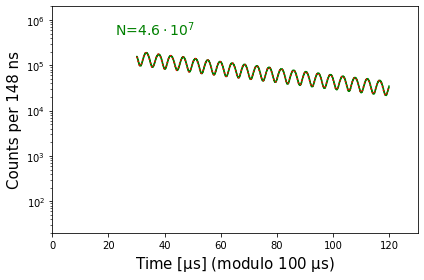

In [28]:

fig, ax = plt.subplots()

ax.step(x=x, y=y, where="post", color="g")
ax.plot(x, blinded_wiggle_function( x, *par) , color="red", label='Fit', linestyle=":")
ax.set_xlim(0, t_mod*1.3)

#log the y 
ax.set_ylim(20, 20e5)
plt.yscale("log")

N_str=cu.sci_notation(N)
cu.textL(ax, 0.28, 0.9, "Run-1 (Quality Tracks > 1.8)N="+N_str, font_size=14)

#axis labels and ticks
plt.ylabel("Counts per "+str(int(binW*1e3))+" ns", fontsize=15)
plt.xlabel(r"Time [$\mathrm{\mu}$s] (modulo "+str(t_mod)+" $\mathrm{\mu}$s)", fontsize=15)


#save  fig 
plt.tight_layout()
plt.savefig("fig/wiggle.png", dpi=300)